In [2]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
sns.set_theme()

In [4]:
df = pd.read_csv("data/train.csv")
display(df)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


In [5]:
df['date_hour'] = pd.to_datetime(df['date_hour'])

def datetime_preprocessing(df):
    df['hour'] = df['date_hour'].dt.hour
    df['dayofweek'] = df['date_hour'].dt.dayofweek
    df['dayofyear'] = df['date_hour'].dt.dayofyear
    df['weekday_name'] = df['date_hour'].dt.day_name()
    df['week_number'] = df['date_hour'].dt.isocalendar().week
    df['month'] = df['date_hour'].dt.month
    df['month_name'] = df['date_hour'].dt.month_name()
    df['year'] = df['date_hour'].dt.year
    season2011 = pd.cut(df['dayofyear'][df['year'] == 2011], bins=[0, 59, 151, 243, 334, 365], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    season2012 = pd.cut(df['dayofyear'][df['year'] == 2012], bins=[0, 60, 152, 244, 335, 366], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    df['season'] = season2011.tolist() + season2012.tolist()
    
    return df

df = datetime_preprocessing(df)
display(df[45:])

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,dayofweek,dayofyear,weekday_name,week_number,month,month_name,year,season
45,2011-01-02 22:00:00,0,1,0.24,0.2121,0.44,0.2985,9,22,6,2,Sunday,52,1,January,2011,winter
46,2011-01-02 23:00:00,0,1,0.22,0.2273,0.47,0.1642,8,23,6,2,Sunday,52,1,January,2011,winter
47,2011-01-03 00:00:00,0,1,0.22,0.1970,0.44,0.3582,5,0,0,3,Monday,1,1,January,2011,winter
48,2011-01-03 01:00:00,0,1,0.20,0.1667,0.44,0.4179,2,1,0,3,Monday,1,1,January,2011,winter
49,2011-01-03 04:00:00,0,1,0.16,0.1364,0.47,0.3881,1,4,0,3,Monday,1,1,January,2011,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,335,Friday,48,11,November,2012,fall
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,335,Friday,48,11,November,2012,fall
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,335,Friday,48,11,November,2012,fall
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,335,Friday,48,11,November,2012,fall


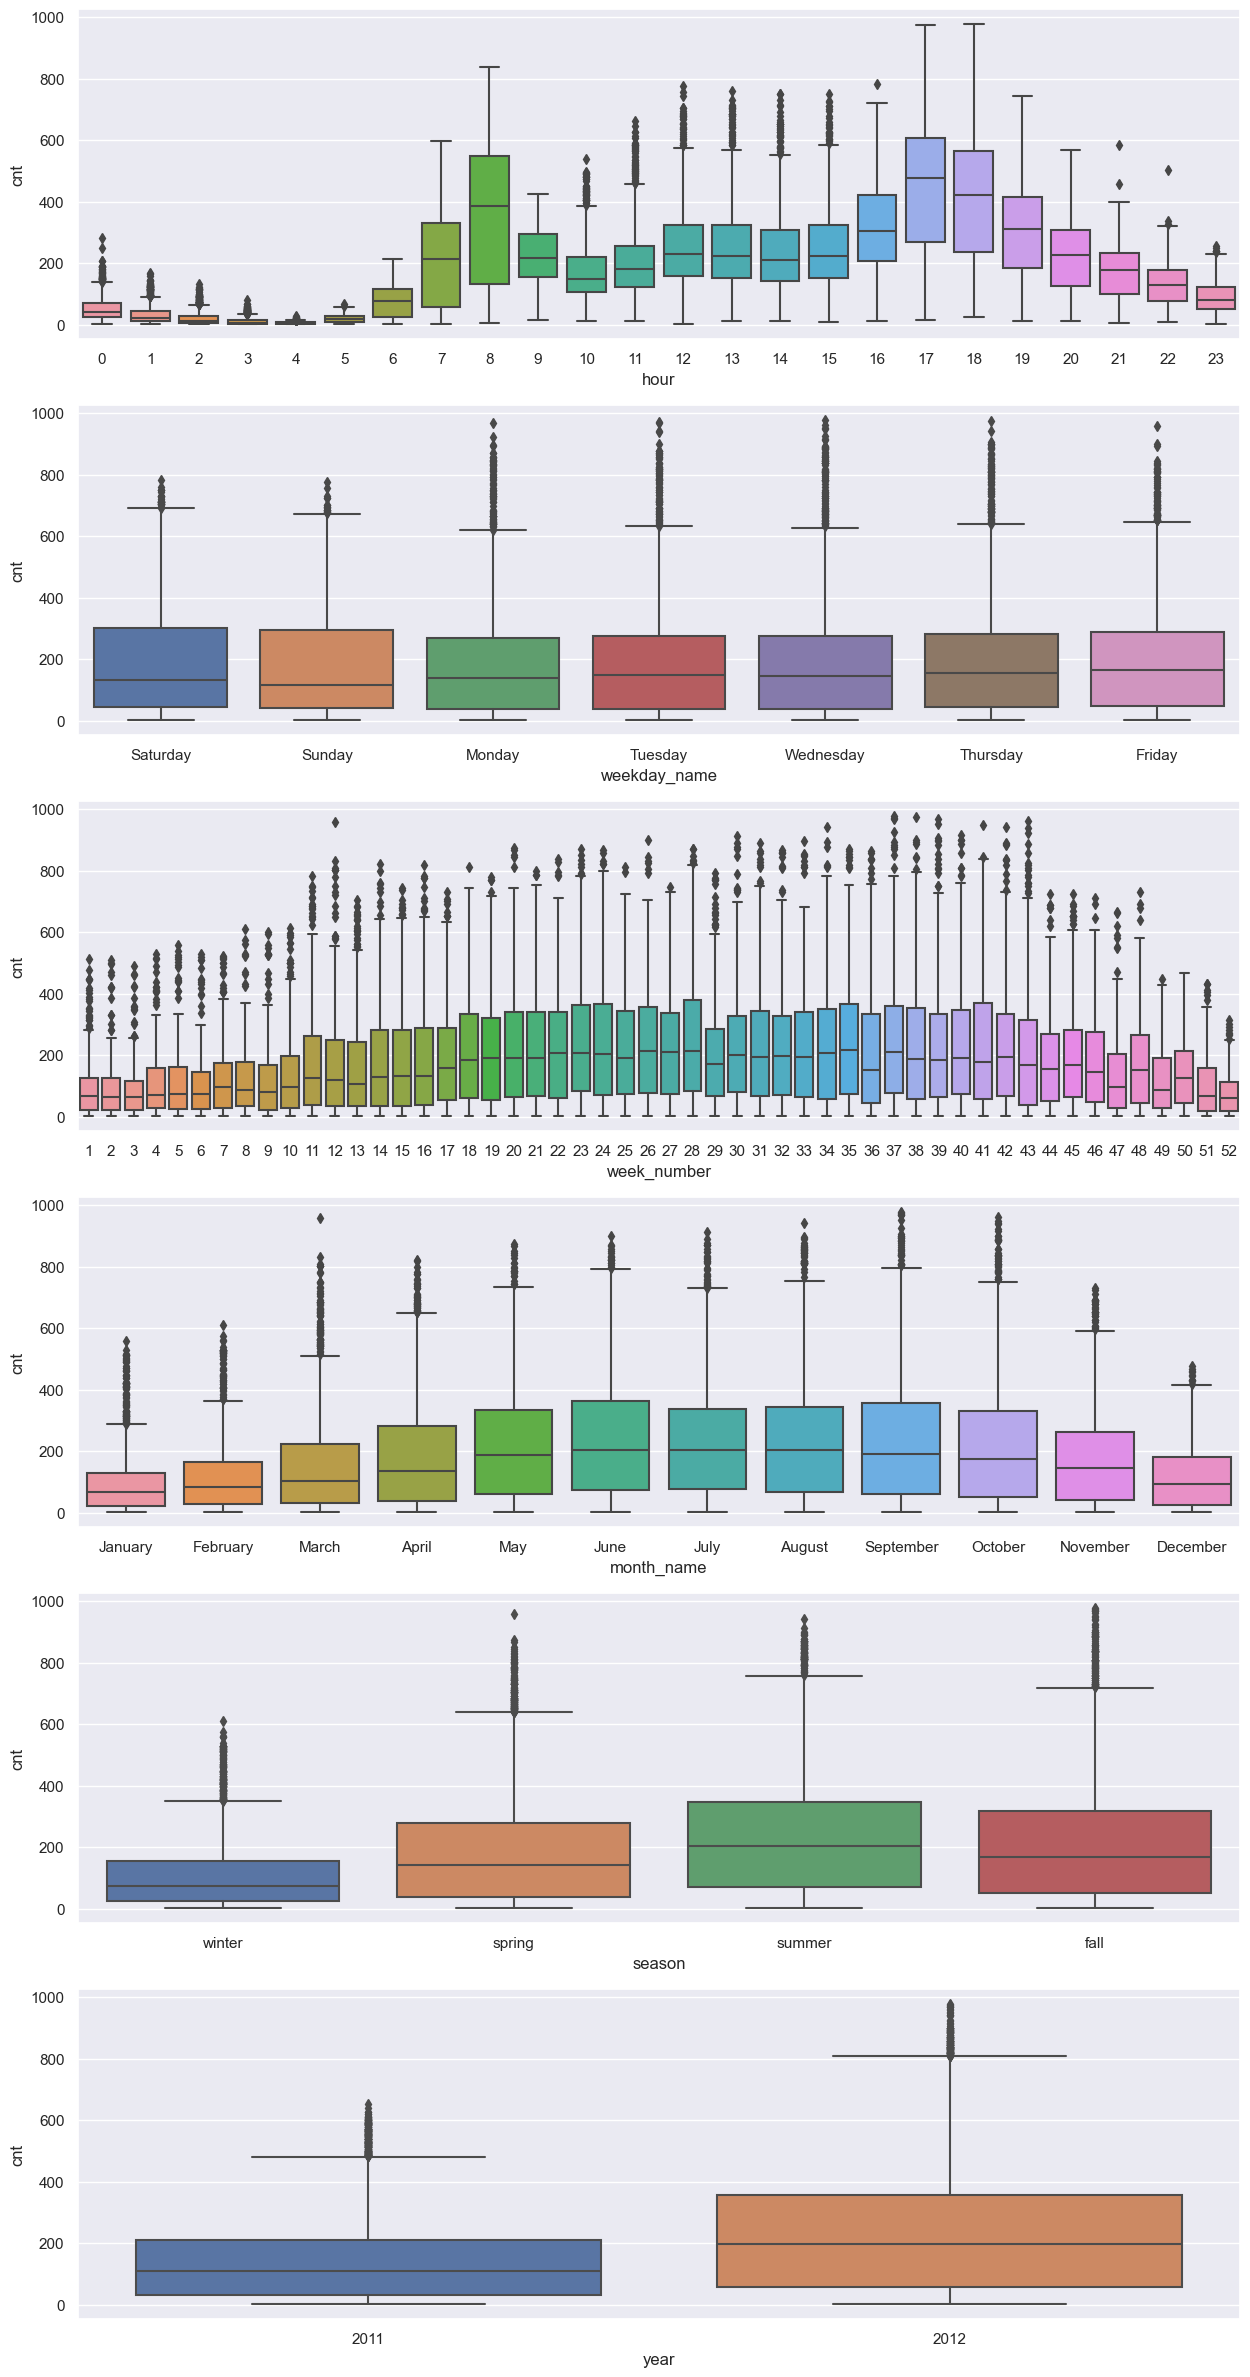

In [6]:
def plot_boxes(df):
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    sns.boxplot(data=df, x='hour', y='cnt', ax=axes[0])
    sns.boxplot(data=df, x='weekday_name', y='cnt', ax=axes[1])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[2])
    sns.boxplot(data=df, x='month_name', y='cnt', ax=axes[3])
    sns.boxplot(data=df, x='season', y='cnt', ax=axes[4])
    sns.boxplot(data=df, x='year', y='cnt', ax=axes[5])
    
plot_boxes(df)

# Time series feature engineering:
### Seizoenspatronen
Seizoenspatronen zijn patronen met een vaste tijdseenheid die pieken of dalen kunnen voorspellen in een tijdserie. Wij hebben dit onderzocht gebruikt makende van een fourier transformatie. Deze transformatie zet de tijdserie om in frequenties met een amplitude. De volgende frequenties hadden een amplitude hoger dan de drempelwaarde die wij hadden gezet op $1.8\cdot{10}^5$. Dit is een waarde waarbij wij vonden dat we de belangrijkste frequenties meenamen. 

Dit zijn de tijdseenheden van de frequenties die zijn waargenomen.
- 1 jaar
- 2/3 jaar (231 dagen)
- 1/2 jaar (173 dagen)
- 1 dag
- 1/2 dag (12 uur)
- 1/3 dag (8 uur)
- 1/5 dag (4.8 uur)

Hier zien wij dat er bij deze tijdseenheden seizoenspatronen zijn. Veel van deze tijdseenheden zijn logisch te verklaren, dit omdat het tijdseenheden zijn die wij een hoop gebruiken in het dagelijks leven.

## Time Series Feature Engineering: Seasonal Patterns
### Seizoenspatronen
Seizoenspatronen, ofwel seizoensgebonden patronen, zijn herhalende trends met een vaste tijdsduur die pieken of dalen in een tijdreeks kunnen voorspellen. Om deze patronen te onderzoeken, hebben we gebruikgemaakt van Fourier-transformatie. Deze transformatie zet de tijdreeks om in frequenties met bijbehorende amplitudes. We hebben een drempelwaarde ingesteld op $1.8\cdot{10}^5$ om alleen frequenties met voldoende significantie te behouden.

De volgende tijdseenheden vertoonden frequenties met een amplitude hoger dan de drempelwaarde:

- 1 jaar
- 2/3 jaar (231 dagen)
- 1/2 jaar (173 dagen)
- 1 dag
- 1/2 dag (12 uur)
- 1/3 dag (8 uur)
- 1/5 dag (4.8 uur)

De keuze van deze tijdseenheden is gebaseerd op de waarde van de amplitude en de relevantie ervan voor de voorspelling van pieken en dalen in de tijdreeks. Het stellen van de drempelwaarde op $1.8\cdot{10}^5$ was een afweging om alleen de meest significante frequenties te behouden.

Het opmerkelijke hierbij is dat veel van deze tijdseenheden overeenkomen met gebruikelijke tijdsduren in ons dagelijks leven. Hierdoor kunnen we logischerwijs verklaren waarom deze frequenties als seizoenspatronen zijn geïdentificeerd.

De geobserveerde tijdseenheden suggereren de aanwezigheid van seizoensgebonden gedrag in de tijdreeks, wat van groot belang kan zijn bij het voorspellen van toekomstige waarden. In de verdere analyse kunnen we deze seizoenspatronen integreren om de nauwkeurigheid van onze voorspellingen te verbeteren.

### Fourier transformatie
De Fourier-transformatie is een krachtige wiskundige techniek die wordt gebruikt om een functie in de tijd (of ruimte) te decomponeren in een reeks sinus- en cosinuscomponenten, ook wel frequentiecomponenten genoemd. Deze transformatie is bijzonder nuttig bij het analyseren van tijdreeksen met seizoenspatronen omdat het ons in staat stelt om de aanwezigheid van cyclische patronen op verschillende tijdschalen te identificeren.

De continue Fourier-transformatie van een functie \(f(t)\) is gegeven door de volgende formule:

$
F(\omega) = \int_{-\infty}^{\infty} f(t) \cdot e^{-i\omega t} \, dt
$

Hierbij is:
- $F(\omega)$ de Fourier-getransformeerde van $f(t)$,
- $\omega$ de frequentie,
- $i$ de imaginaire eenheid $(i^2 = -1)$,
- $t$ de tijd, en
- $f(t)$ de oorspronkelijke functie in de tijd.

De discrete vorm van de Fourier-transformatie, die vaak wordt toegepast op discrete tijdreeksen, zoals in ons geval, is gegeven door:

$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i \frac{2\pi}{N}kn}
$

Hierbij is:
- $X_k$ de $k$-de component van de Fourier-getransformeerde,
- $x_n$ het $n$-de punt in de tijdreeks,
- $N$ het totale aantal punten in de tijdreeks, en
- $k$ de index van de frequentiecomponent.

Wanneer we de Fourier-transformatie toepassen op een tijdreeks, krijgen we een spectrum van frequentiecomponenten, elk met een bijbehorende amplitude. In het geval van tijdreeksen met seizoenspatronen, zullen bepaalde frequenties en hun amplitudes opvallen, wat aangeeft welke cyclische patronen aanwezig zijn in de data.

Door deze seizoensgebonden frequenties te identificeren en hun amplitudes te analyseren, kunnen we inzicht krijgen in de regelmatige patronen die zich herhalen in de tijdreeks. Dit stelt ons in staat om beter voorbereid te zijn op toekomstige schommelingen en deze in overweging te nemen bij het maken van voorspellingen.


In [7]:
def fft_freq(values, threshold):
    fig = plt.figure(figsize=(10, 4))
    
    freq = np.fft.fftfreq(len(values), 1)
    raw_result = np.fft.fft(values)
    
    cleaned_raw_result =  np.array([x if (x >= threshold*10**5) | (x <= -threshold*10**5) else 0 for x in raw_result])
    
    result = np.abs(raw_result)
    
    cleaned_result = np.array([x if (x >= threshold*10**5) & (y > 0) else 0 for x, y in zip(result, freq)])
    
    plt.plot(freq, raw_result)
    plt.xlim([-0.02, 0.13])
    plt.ylim([-5*10**5, 3.5*10**6])
    plt.axhline(threshold*10**5, color='green', dashes=(5, 5))
    
    fft_df = pd.DataFrame({'amplitude':cleaned_result[cleaned_result > 0][1:]})
    fft_df['freq'] = freq[cleaned_result > 0][1:]
    fft_df['duur in uren'] = 1/fft_df['freq']
    fft_df['duur in dagen'] = 1/fft_df['freq']/24
    fft_df['duur in maanden'] = 1/fft_df['freq']/24/(365/12)
    fft_df['duur in jaren'] = 1/fft_df['freq']/24/365
    
    fft_df['freq'] = [fft_df['freq'][0]] + [x if (x-y > x*0.1) else None 
                           for x, y in zip(fft_df['freq'][1:], fft_df['freq'][:-1])]
    
    fft_df = fft_df.dropna().reset_index(drop=True)
    
    
    return fft_df, freq, cleaned_raw_result

C:\Users\Mark\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


,amplitude,freq,duur in uren,duur in dagen,duur in maanden,duur in jaren
0,560236.241034,0.000120,8318.500000,346.604167,11.395205,0.949600
1,217822.744688,0.000180,5545.666667,231.069444,7.596804,0.633067
2,249918.605480,0.000240,4159.250000,173.302083,5.697603,0.474800
3,702799.953019,0.041594,24.041908,1.001746,0.032934,0.002745
4,306064.251401,0.077418,12.916925,0.538205,0.017694,0.001475
5,204856.186038,0.124962,8.002405,0.333434,0.010962,0.000914
6,180934.849803,0.208271,4.801443,0.200060,0.006577,0.000548


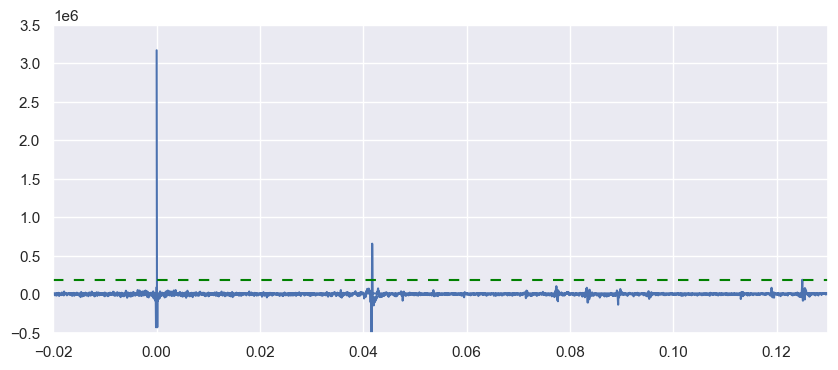

In [8]:
fft_df, freq, result = fft_freq(df['cnt'], 1.8)
display(fft_df)

### Inverse fourier transformatie
Nu we de fourier transformatie hebben gedaan, de waardes hebben opgeschoond en de relevante frequenties hebben. Kunnen we de inverse van de fourier transformatie uitvoeren. Dit betekent dat we van frequenties en amplitudes weer terug gaan naar een tijd reeks. Hiermee kunnen we zien wat de impact is van de meest relevante frequenties en hoe de grafiek eruit had gezien als we alleen deze frequenties in de data zouden hebben.

,date_hour,cnt,week
0,2011-01-01 00:00:00,187.990890,52
1,2011-01-01 01:00:00,184.437853,52
2,2011-01-01 02:00:00,165.951396,52
3,2011-01-01 03:00:00,140.646468,52
4,2011-01-01 04:00:00,120.002589,52
...,...,...,...
16632,2012-11-30 19:00:00,146.349680,48
16633,2012-11-30 20:00:00,138.358083,48
16634,2012-11-30 21:00:00,142.132687,48
16635,2012-11-30 22:00:00,157.456688,48


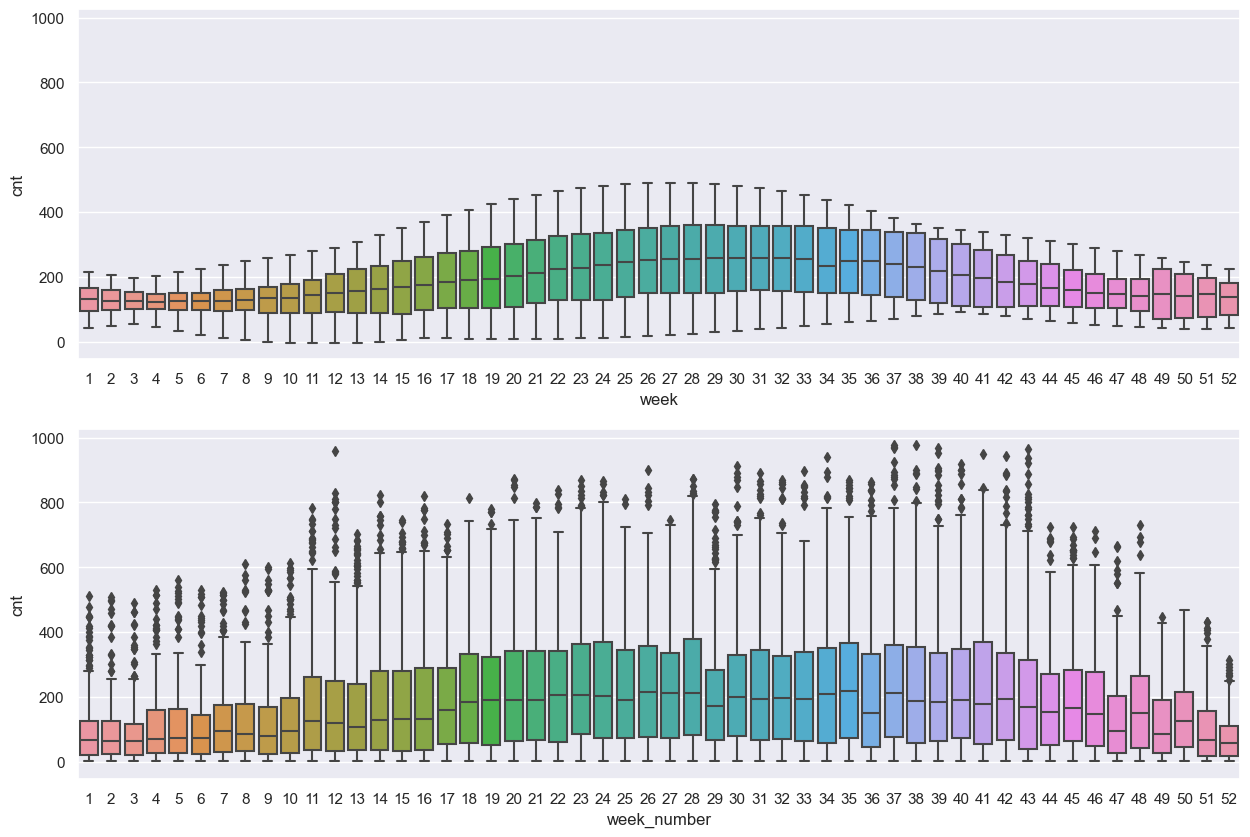

In [9]:
def inverted_fft(freq, result, df):
    cnt = np.fft.ifft(result).real
    
    ifft_df = pd.DataFrame({'date_hour': df['date_hour'], 'cnt': cnt})
    ifft_df['week'] = ifft_df['date_hour'].dt.isocalendar().week

    return ifft_df
    
def compare_ifft(df, ifft_df):
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)
    sns.boxplot(x=ifft_df['week'], y=ifft_df['cnt'], ax=axes[0])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[1])
    
    
ifft_df = inverted_fft(freq, result, df)
display(ifft_df)

compare_ifft(df, ifft_df)

### Feature engineering
Door te kijken naar de frequenties die uit de fourier analyse komt kunnen wij extra kolommen toevoegen die sinus en cosinus golven toevoegd als kolom. Hierdoor kan een model deze frequenties ook benutten en zo zorgen voor betere voorspellingen. Dit helpt het model aangezien er al een hoop van het werk is gedaan om de huidige tijdsreeks na te bootsen.

In [75]:
annual_fourier = CalendarFourier(freq='A', order =  1)
quarterly_fourier = CalendarFourier(freq='M', order =  1)
daily_fourier = CalendarFourier(freq='D', order = 1)

In [76]:
dp = DeterministicProcess(index=df['date_hour'], constant=False, order=0, seasonal=False,
                          additional_terms = [annual_fourier, quarterly_fourier, daily_fourier], drop = False)

fourier_terms = dp.in_sample().reset_index()
fourier_terms['date_hour'] = pd.to_datetime(fourier_terms['date_hour'])
display(fourier_terms)

,date_hour,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=M)","cos(1,freq=M)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2011-01-01 01:00:00,0.000717,1.000000,0.008445,0.999964,0.258819,0.965926
2,2011-01-01 02:00:00,0.001435,0.999999,0.016889,0.999857,0.500000,0.866025
3,2011-01-01 03:00:00,0.002152,0.999998,0.025333,0.999679,0.707107,0.707107
4,2011-01-01 04:00:00,0.002869,0.999996,0.033774,0.999429,0.866025,0.500000
...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,-0.510494,0.859881,-0.043619,0.999048,-0.965926,0.258819
16633,2012-11-30 20:00:00,-0.509879,0.860246,-0.034899,0.999391,-0.866025,0.500000
16634,2012-11-30 21:00:00,-0.509263,0.860611,-0.026177,0.999657,-0.707107,0.707107
16635,2012-11-30 22:00:00,-0.508647,0.860975,-0.017452,0.999848,-0.500000,0.866025


(14975.0, 14977.0)

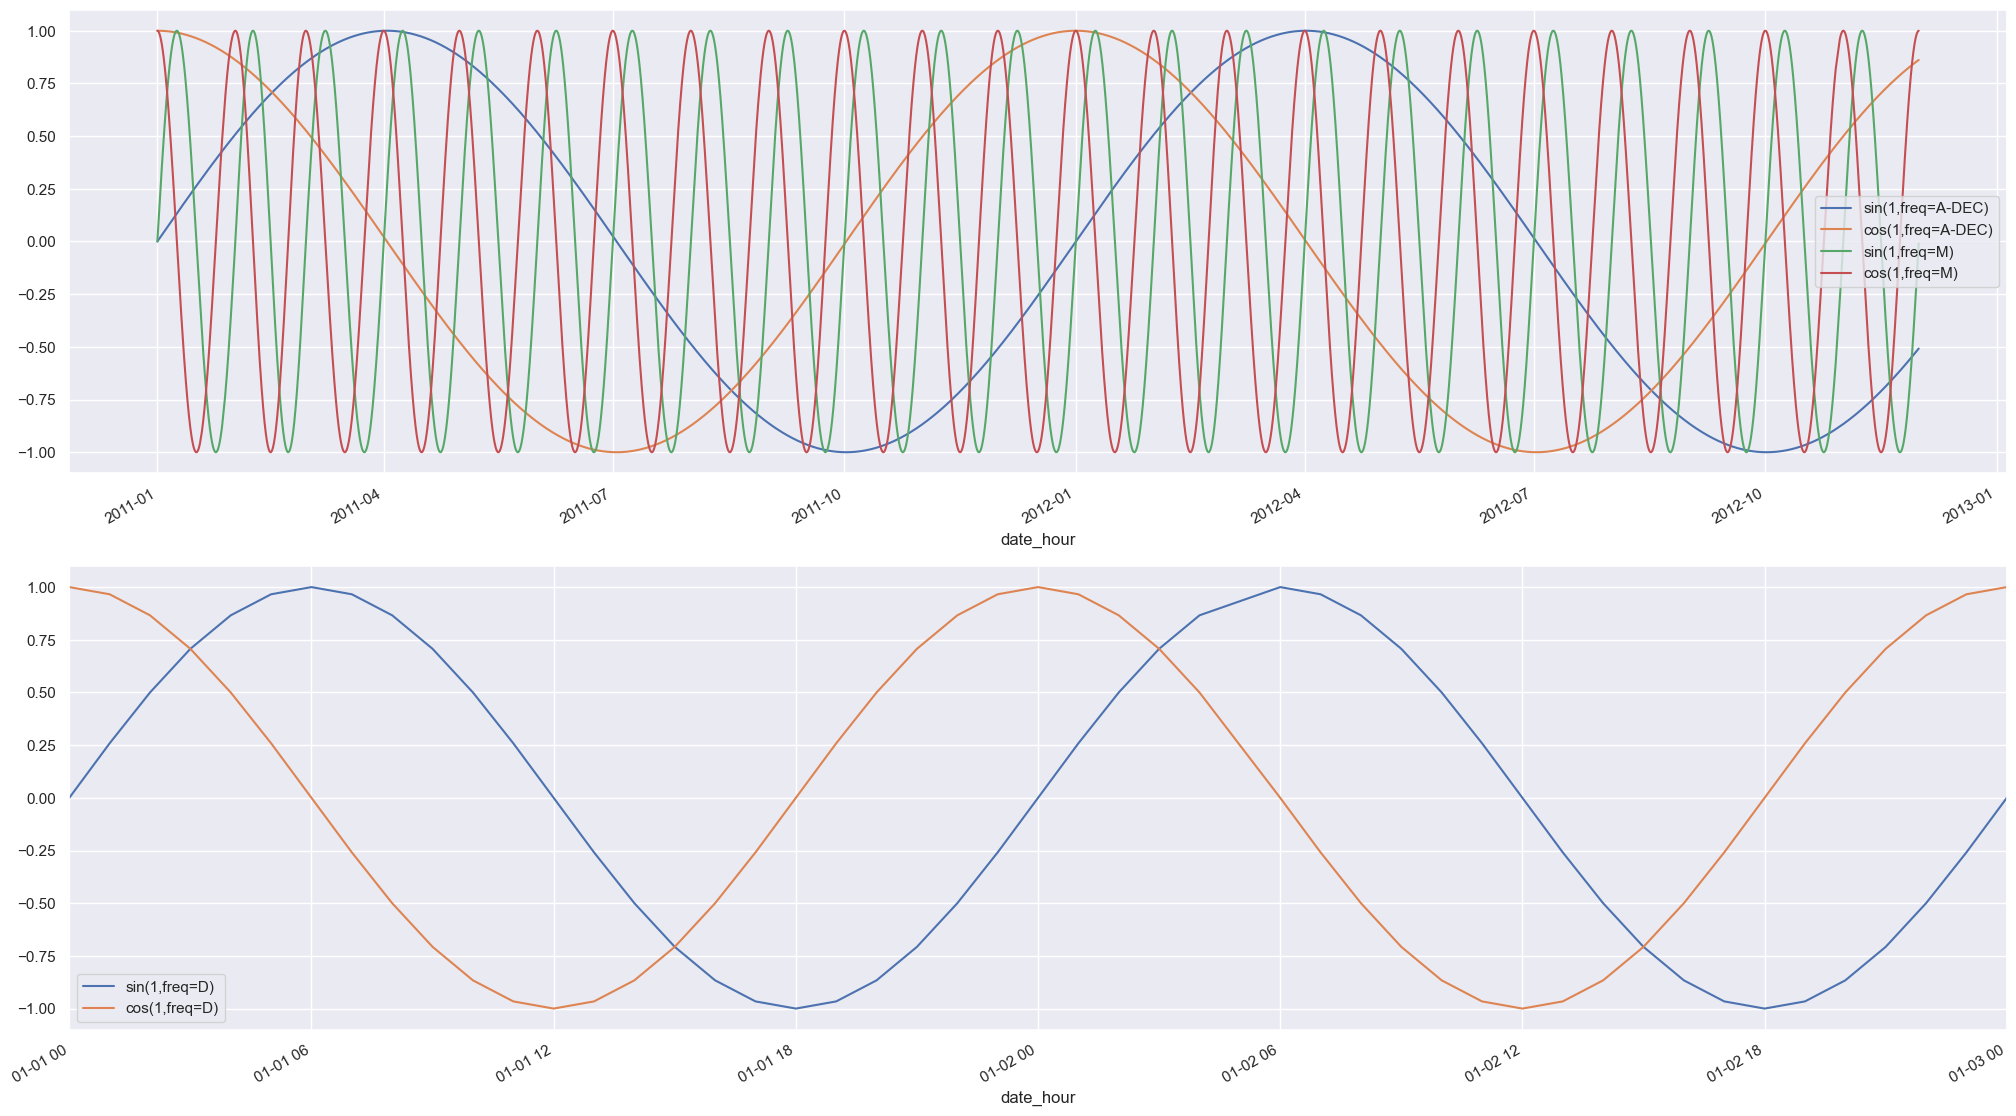

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[1], x=('date_hour'))
ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[2], x=('date_hour'))

ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[3], x=('date_hour'))
ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[4], x=('date_hour'))

ax[1] = fourier_terms.plot(ax=ax[1], y=fourier_terms.columns[5], x=('date_hour'))
ax[1] = fourier_terms.plot(ax=ax[1], y=fourier_terms.columns[6], x=('date_hour'))


day_start_date = pd.to_datetime('2011-01-01')
day_end_date = pd.to_datetime('2011-01-03')

ax[1].set_xlim(day_start_date, day_end_date)

In [74]:
cleaned_fourier_terms = fourier_terms.drop(['date_hour'], axis=1)

In [ ]:
df = pd.concat([df, cleaned_fourier_terms], axis=1)
display(df)

## Autocorrelatie
Autocorrelatie verwijst naar de correlatie van een tijdreeks met zichzelf, gemeten op verschillende tijdsafstanden. Het kan helpen om patronen in de tijdreeks te identificeren en is essentieel bij het begrijpen van zowel cycli als seizoenspatronen.

### Partial autocorrelatie
Partial autocorrelatie is de autocorrelatie maar dan zonder terugkerende seizoenspatronen. Dit houdt in dat als je al een patroon hebt herkend bij bijvoorbeeld 24 uur dan word dit signaal onderdrukt elke nieuwe instantie van 24 uur. Hierdoor kan je makkelijker zien over er overlappende seizoenspatronen of cycli voorkomen en deze gebruiken voor de analyse van de tijdsreeks.

### Autocorrelatie en cycli:

Cycli in een tijdreeks verwijzen naar langere-termijnpatronen die zich herhalen, maar niet noodzakelijk met een vast tijdsinterval zoals seizoenspatronen. Cycli kunnen bijvoorbeeld betrekking hebben op economische cycli, die jaren kunnen beslaan. Wanneer we de autocorrelatiefunctie (ACF) toepassen op een tijdreeks met cycli, zullen we pieken zien op de momenten waarop de cycli herhalen.

### Autocorrelatie en seizoenspatronen:

Seizoenspatronen hebben betrekking op regelmatige fluctuaties in een tijdreeks met een vast tijdsinterval, zoals dagelijks, maandelijks of jaarlijks. Wanneer we de autocorrelatie toepassen op een tijdreeks met seizoenspatronen, zullen we duidelijke pieken zien op veelvouden van het seizoensinterval. Bijvoorbeeld, als het seizoensinterval dagelijks is, zouden we pieken verwachten op 24, 48, 72 enzovoort.

### Waarom cycli anders zijn dan seizoenspatronen:

Het belangrijkste verschil tussen cycli en seizoenspatronen ligt in de duur en het karakter van herhaling. Cycli hebben vaak een langere duur en minder consistente tijdsintervallen tussen herhalingen. Seizoenspatronen, aan de andere kant, hebben meestal een kortere en regelmatig herhalende duur.

Bij het analyseren van de autocorrelatie is het van belang om zowel cycli als seizoenspatronen in overweging te nemen, omdat beide types patronen van invloed kunnen zijn op het gedrag van de tijdreeks. Het identificeren van deze patronen met behulp van autocorrelatieanalyses kan helpen bij het modelleren en voorspellen van toekomstige waarden in de tijdreeks.

In [ ]:
def auto_correlation(df):
    fig, ax = plt.subplots(2, 1, figsize=(20, 15))
    plot_acf(df['cnt'], ax=ax[0], lags=24*7)
    plot_pacf(df['cnt'], ax=ax[1], lags=24*7)

auto_correlation(df)